In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
from skimage.feature import hog
% matplotlib inline

In [2]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

In [3]:
def data_look(car_list,notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    image = cv2.imread(notcar_list[0])
    data_dict["image_shape"] = image.shape
    data_dict["data_type"] = image.dtype
    return data_dict

In [4]:
data_dict = data_look(cars,notcars)
print(data_dict)

{'data_type': dtype('uint8'), 'n_cars': 8792, 'n_notcars': 8968, 'image_shape': (64, 64, 3)}


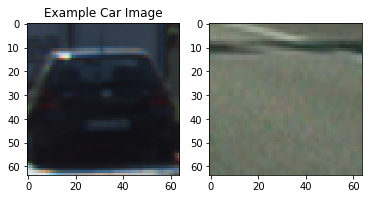

In [5]:
# choose two random indices
car_ind = np.random.randint(0,data_dict["n_cars"])
notcar_ind = np.random.randint(0,data_dict["n_notcars"])
# read the images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])
car_image = cv2.cvtColor(car_image,cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(notcar_image,cv2.COLOR_BGR2RGB)
# plot the image
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)

## Extract HOG features 

In [6]:
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=True,feature_vec=True):
    if vis:
        features,hog_image = hog(img, orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell)\
            ,cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec,block_norm="L2-Hys")
        return features,hog_image
    else:
        features = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell), \
                      cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec,block_norm="L2-Hys")
        return features

In [7]:
def color_hist(img,nbins=32,bin_range=(0,256)):
    channel_1_hist = np.histogram(img[:,:,0],bins=32,range=bin_range)
    channel_2_hist = np.histogram(img[:,:,1],bins=32,range=bin_range)
    channel_3_hist = np.histogram(img[:,:,2],bins=32,range=bin_range)
    hist_feature = np.concatenate([channel_1_hist[0],channel_2_hist[0],channel_3_hist[0]])
    
    return hist_feature

In [8]:
def spatial_feature(img,size=(32,32)):
    # return a one dimensional feature vector
    features = cv2.resize(img,size).ravel()
   
    return features

In [9]:
# hog_channel can take values of 0, 1, 2, or "ALL"
# meaning that you extract HOG features from the first, second, third, or all color channels respectively.
def extract_features(imgs,cspace,spatial_size,nbins,bin_range,orient,pix_per_cell,cell_per_block,hog_channel,\
                     spatial_feat=True,hist_feat=True,hog_feat=True):
    
    feature_list = []
    for filename in imgs:
        features = []
        image = cv2.imread(filename)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
       
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            if cspace == 'YCrCb':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
            if cspace == 'YUV':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
       
        # Compute spatial features if flag is set
        if spatial_feat == True:
            feature = spatial_feature(image,spatial_size)
            features.append(feature)
        
        # Compute histogram features if flag is set
        if hist_feat == True:
            feature = color_hist(image,nbins,bin_range).astype(np.float64)
            features.append(feature)
          
        
        # Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(image.shape[2]):
                    feature = get_hog_features(image[:,:,channel],orient,pix_per_cell,cell_per_block,vis=False)
                    hog_features.append(feature)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(image[:,:,hog_channel],orient,pix_per_cell,cell_per_block,vis=False)
            features.append(hog_features)
        
        feature_list.append(np.concatenate(features))
        
    return feature_list

In [10]:
cspace = 'YUV'
spatial_size = (32,32)
nbins = 32
bin_range = (0,256)
orient = 13
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

In [11]:
car_features = extract_features(cars, cspace, spatial_size, nbins, bin_range, orient\
             , pix_per_cell, cell_per_block, hog_channel)

In [12]:
notcar_features = extract_features(notcars,cspace, spatial_size, nbins, bin_range, orient\
             , pix_per_cell, cell_per_block, hog_channel)

In [13]:
X = np.vstack((car_features,notcar_features)).astype(np.float64)

In [14]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

scaler.fit(X)

# data = (data - mean) / np.sqrt(var)
scaled_X = scaler.transform(X)

In [17]:
# Split data into randomized training and test sets
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size=0.2,random_state=rand_state)

In [18]:
from sklearn.svm import LinearSVC
# Use a linear SVC 
svc = LinearSVC()

In [19]:
svc.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [20]:
svc.score(X_test, y_test)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


0.99042792792792789

In [21]:
from sklearn.externals import joblib

In [25]:
joblib.dump(svc, 'classifier.pkl') 

['classifier.pkl']

### check the score of the SVC

In [26]:
svc = joblib.load('classifier.pkl') 

In [27]:
print('SVC predicts: ', svc.predict(X_test[0:10]))
print('For these 10 labels:', y_test[0:10])

SVC predicts:  [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  1.]
For these 10 labels: [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  1.]


In [28]:
# take an image (not file name) as input
def single_img_features(img,cspace='RGB',spatial_size=(32,32),nbins=32,bin_range=(0,256),orient=9,\
        pix_per_cell=8, cell_per_block=2,hog_channel=0,spatial_feat=True,hist_feat=True,hog_feat=True):
    # Define an empty list to receive features
    features = []
    # Apply color conversion if other than 'RGB'
   
    if cspace != 'RGB':
        if cspace == 'HSV':
            cvt_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        
        if cspace == 'YCrCb':
            cvt_img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
        
    else:
        cvt_img = img.copy()
   
    # Compute spatial features if flag is set
    if spatial_feat == True:
        feature = spatial_feature(cvt_img,spatial_size).astype(np.float64)
        #print(feature.shape)
        features.append(feature)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        feature = color_hist(cvt_img,nbins,bin_range).astype(np.float64)
        #print(feature.shape)
        features.append(feature)
    

    # Compute HOG features if flag is set
    if hog_feat == True:
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(cvt_img.shape[2]):
                feature = get_hog_features(img[:,:,channel],orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
                feature = feature.ravel()
                #print(feature.shape)
                hog_features.append(feature)
                
                
            hog_features = np.ravel(hog_features)
            
        
        else:
            hog_features = get_hog_features(img[:,:,hog_channel],orient,pix_per_cell,cell_per_block,vis=False)
     
        features.append(hog_features)
        
    return np.concatenate(features)

In [29]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7)):
    window_list = []
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    nx_pix_per_step = xy_window[0] * (1 - xy_overlap[0])
    ny_pix_per_step = xy_window[1] * (1 - xy_overlap[1])
    
    nx_window = np.int32((x_start_stop[1] - x_start_stop[0]) / nx_pix_per_step)
    ny_window = np.int32((y_start_stop[1] - y_start_stop[0]) / ny_pix_per_step)
    
    
    for i in range(nx_window-1):
        for j in range(ny_window-1):
            offset_x = i * nx_pix_per_step + x_start_stop[0]
            offset_y = j * ny_pix_per_step + y_start_stop[0]
            top_left = (np.int32(offset_x),np.int32(offset_y))
            bottom_right = (np.int32(offset_x + xy_window[0]), np.int32(offset_y + xy_window[1]))
            window_list.append((top_left,bottom_right))
    return window_list
    

In [30]:
def search_windows(img,windows,svc):
    hot = []
   
    for window in windows:
        #print(img[window[0][1]:window[1][1],window[0][0]:window[1][0]].shape)
        test_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]],(64,64))
       
       
        feature = single_img_features(test_img,cspace='HSV',spatial_size=(32,32),nbins=32,bin_range=(0,256),orient=9,\
            pix_per_cell=8, cell_per_block=2,hog_channel='ALL',spatial_feat=True,hist_feat=True,hog_feat=True)
        
       
        # Scale extracted features to be fed to classifier
        feature = feature.reshape(1,-1)
        
        scaled_feature = scaler.transform(feature)
        
        prediction = svc.predict(scaled_feature)
      
        if prediction == 1:
            hot.append(window)

    return hot

In [31]:
def draw_boxes(image,bboxes,color=(0,0,255),thickness=6):
    img_copy = image.copy()
    for bbox in bboxes:
        cv2.rectangle(img_copy,bbox[0],bbox[1],color,thickness)
    return img_copy

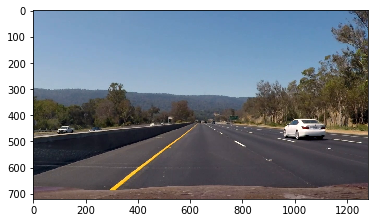

In [35]:
image = cv2.imread('test_images/test9.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [30]:
windows = slide_window(image,x_start_stop=[None,None],y_start_stop=[350,720],xy_window=(64,64),xy_overlap=(0.5,0.5))

In [31]:
hot_windows  = search_windows(image,windows,svc)

ValueError: operands could not be broadcast together with shapes (1,8460) (9636,) (1,8460) 

In [ ]:
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thickness=6)  

In [32]:
plt.imshow(window_img)

NameError: name 'window_img' is not defined

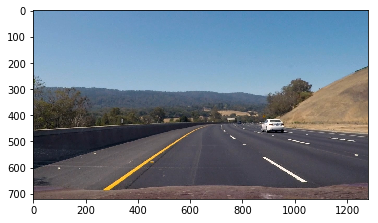

In [61]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [41]:
def convert_color(img,conv):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YUV)

In [38]:
def find_cars(img,scale,orient,pix_per_cell,cell_per_block,svc,cells_per_step,ystart,ystop,xstart,xstop):
    
    bbox_list = []
    
    draw_img = img.copy()
    window = 64
    features = []

    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    img_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        img_tosearch = cv2.resize(img_tosearch,(np.int(img_tosearch.shape[1]/scale), np.int(img_tosearch.shape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]
    
    nx_blocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    ny_blocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    nx_steps = (nx_blocks - nblocks_per_window) // cells_per_step + 1
    ny_steps = (ny_blocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
    hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
    hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
   
  
    for x in range(nx_steps):
        for y in range(ny_steps):
           
            features = []
            ypos = y * cells_per_step
            xpos = x * cells_per_step
        
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = img_tosearch[ytop:ytop+window,xleft:xleft+window]
           
            # Get features
            feature = spatial_feature(subimg,spatial_size).astype(np.float64)
            features.append(feature)
        
            hist_features = color_hist(subimg,nbins,bin_range).astype(np.float64)
            features.append(hist_features)
            
            # Extract HOG for this patch
            hog1_feature = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog2_feature = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog3_feature = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
           
           
            features.append(hog1_feature)
            features.append(hog2_feature)
            features.append(hog3_feature)
    
            features = np.hstack(features).reshape(1,-1)
            # Scale features
            scaled_feature = scaler.transform(features)
            predict = svc.predict(scaled_feature)
            
            
            if predict:
                score = svc.decision_function(scaled_feature)
                #print(score)
                
                xleft_draw = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                window_draw = np.int(window * scale)
                left_top = (xleft_draw+xstart, ytop_draw+ystart)
                right_bottom = (xleft_draw+window_draw+xstart,ytop_draw+window_draw+ystart)
                bbox_list.append((left_top,right_bottom))
                cv2.rectangle(draw_img,(xleft_draw+xstart, ytop_draw+ystart),(xleft_draw+window_draw+xstart,ytop_draw+window_draw+ystart)\
                    ,(0,0,255),6) 
   
    return draw_img,bbox_list

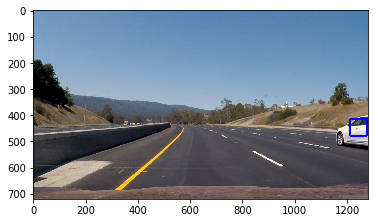

In [53]:
image = cv2.imread('test_images/test11.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 1
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,350,478,300,1280)
cv2.line(draw_img,(400,0),(400,720),color=(0,255,0),thickness=1)
plt.imshow(draw_img)

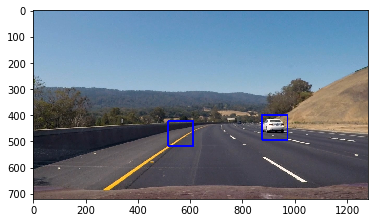

In [818]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 1.5
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,350,542,300,1280)
plt.imshow(draw_img)

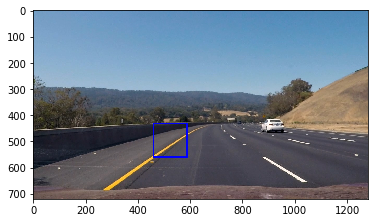

In [819]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 2
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,400,656,300,1280)
plt.imshow(draw_img)

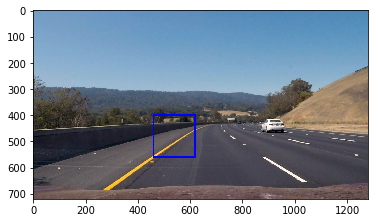

In [820]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 2.5
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,400,720,300,1280)
plt.imshow(draw_img)

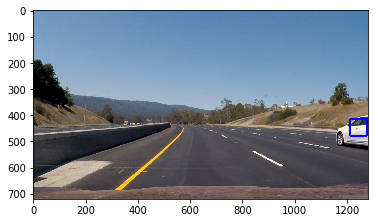

In [54]:
image = cv2.imread('test_images/test11.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
bbox_list = []
scales = [1,1.5,2,2.5]
draw_img,box_list = find_cars(image,scales[0],13,16,2,svc,1,350,478,300,1280)
plt.imshow(draw_img)
bbox_list.extend(box_list)
draw_img,box_list = find_cars(image,scales[1],13,16,2,svc,1,350,542,300,1280)
bbox_list.extend(box_list)
draw_img,box_list = find_cars(image,scales[2],13,16,2,svc,1,400,656,300,1280)
bbox_list.extend(box_list)
draw_img,box_list = find_cars(image,scales[3],13,16,2,svc,1,400,720,300,1280)
bbox_list.extend(box_list)
#cv2.line(draw_img, (0,520), (1280,520), (0,255,0), thickness=5)
#plt.imshow(draw_img)

In [58]:
from scipy.ndimage.measurements import label

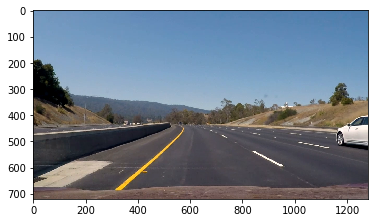

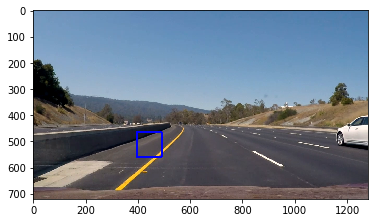

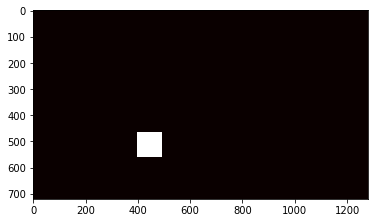

In [59]:
plt.imshow(image)
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,bbox_list)
heatmap = apply_threshold(heatmap,3)
labeled_array, num_features = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labeled_array, num_features)
plt.figure()
plt.imshow(draw_img)
plt.figure()
plt.imshow(heatmap, cmap='hot')

In [160]:
def process_image(image):
    mpimg.imsave("test11.jpg",image)
    bbox_list = []
    scales = [1,1.5,2,2.5]
    draw_img,box_list = find_cars(image,scales[0],13,16,2,svc,1,350,478,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[1],13,16,2,svc,1,350,542,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[2],13,16,2,svc,1,400,656,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[3],13,16,2,svc,1,400,720,300,1280)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap,bbox_list)
    heatmap = apply_threshold(heatmap,3)
    labeled_array, num_features = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labeled_array, num_features)
    return draw_img

In [267]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'output7.mp4'
#heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
clip1 = VideoFileClip("project_video.mp4")
new_clip = clip1.fl_image(process_image)
new_clip.write_videofile(output,audio=False)

[MoviePy] >>>> Building video output7.mp4
[MoviePy] Writing video output7.mp4








  0%|          | 0/1261 [00:00<?, ?it/s]





  0%|          | 1/1261 [00:01<23:03,  1.10s/it]





  0%|          | 2/1261 [00:03<28:36,  1.36s/it]





  0%|          | 3/1261 [00:04<30:20,  1.45s/it]





  0%|          | 4/1261 [00:06<30:18,  1.45s/it]





  0%|          | 5/1261 [00:07<28:58,  1.38s/it]





  0%|          | 6/1261 [00:08<27:02,  1.29s/it]





  1%|          | 7/1261 [00:09<24:38,  1.18s/it]





  1%|          | 8/1261 [00:10<24:43,  1.18s/it]





  1%|          | 9/1261 [00:11<23:37,  1.13s/it]





  1%|          | 10/1261 [00:12<23:15,  1.12s/it]





  1%|          | 11/1261 [00:13<22:26,  1.08s/it]





  1%|          | 12/1261 [00:14<21:53,  1.05s/it]





  1%|          | 13/1261 [00:15<23:07,  1.11s/it]





  1%|          | 14/1261 [00:17<24:17,  1.17s/it]





  1%|          | 15/1261 [00:18<23:08,  1.11s/it]





  1%|▏         | 16/1261 [00:19<21:39,  1.04s/it]





  1%|▏         | 17/1261 [00:19<20:44,  1.00s/it]





  1%|▏         | 18/12

 18%|█▊        | 222/1261 [04:16<19:44,  1.14s/it]





 18%|█▊        | 223/1261 [04:17<18:55,  1.09s/it]





 18%|█▊        | 224/1261 [04:18<18:26,  1.07s/it]





 18%|█▊        | 225/1261 [04:19<17:58,  1.04s/it]





 18%|█▊        | 226/1261 [04:20<18:13,  1.06s/it]





 18%|█▊        | 227/1261 [04:21<17:44,  1.03s/it]





 18%|█▊        | 228/1261 [04:22<17:32,  1.02s/it]





 18%|█▊        | 229/1261 [04:23<17:27,  1.01s/it]





 18%|█▊        | 230/1261 [04:24<18:10,  1.06s/it]





 18%|█▊        | 231/1261 [04:25<20:06,  1.17s/it]





 18%|█▊        | 232/1261 [04:27<20:28,  1.19s/it]





 18%|█▊        | 233/1261 [04:28<20:19,  1.19s/it]





 19%|█▊        | 234/1261 [04:29<20:37,  1.21s/it]





 19%|█▊        | 235/1261 [04:30<20:41,  1.21s/it]





 19%|█▊        | 236/1261 [04:31<20:20,  1.19s/it]





 19%|█▉        | 237/1261 [04:33<19:51,  1.16s/it]





 19%|█▉        | 238/1261 [04:33<18:37,  1.09s/it]





 19%|█▉        | 239/1261 [04:34<17:44,  1.04s/i

 35%|███▌      | 442/1261 [08:16<14:28,  1.06s/it]





 35%|███▌      | 443/1261 [08:17<14:00,  1.03s/it]





 35%|███▌      | 444/1261 [08:18<13:41,  1.01s/it]





 35%|███▌      | 445/1261 [08:19<14:16,  1.05s/it]





 35%|███▌      | 446/1261 [08:20<14:50,  1.09s/it]





 35%|███▌      | 447/1261 [08:21<14:19,  1.06s/it]





 36%|███▌      | 448/1261 [08:22<14:03,  1.04s/it]





 36%|███▌      | 449/1261 [08:23<14:42,  1.09s/it]





 36%|███▌      | 450/1261 [08:25<15:02,  1.11s/it]





 36%|███▌      | 451/1261 [08:26<15:00,  1.11s/it]





 36%|███▌      | 452/1261 [08:27<14:51,  1.10s/it]





 36%|███▌      | 453/1261 [08:28<14:18,  1.06s/it]





 36%|███▌      | 454/1261 [08:29<13:45,  1.02s/it]





 36%|███▌      | 455/1261 [08:30<13:24,  1.00it/s]





 36%|███▌      | 456/1261 [08:31<13:21,  1.00it/s]





 36%|███▌      | 457/1261 [08:32<13:22,  1.00it/s]





 36%|███▋      | 458/1261 [08:33<13:33,  1.01s/it]





 36%|███▋      | 459/1261 [08:34<13:19,  1.00it/

 52%|█████▏    | 662/1261 [12:08<10:17,  1.03s/it]





 53%|█████▎    | 663/1261 [12:09<10:11,  1.02s/it]





 53%|█████▎    | 664/1261 [12:10<10:05,  1.01s/it]





 53%|█████▎    | 665/1261 [12:11<10:04,  1.01s/it]





 53%|█████▎    | 666/1261 [12:12<10:03,  1.01s/it]





 53%|█████▎    | 667/1261 [12:13<09:51,  1.00it/s]





 53%|█████▎    | 668/1261 [12:14<09:56,  1.01s/it]





 53%|█████▎    | 669/1261 [12:15<09:46,  1.01it/s]





 53%|█████▎    | 670/1261 [12:16<09:34,  1.03it/s]





 53%|█████▎    | 671/1261 [12:17<09:30,  1.03it/s]





 53%|█████▎    | 672/1261 [12:18<09:27,  1.04it/s]





 53%|█████▎    | 673/1261 [12:19<09:25,  1.04it/s]





 53%|█████▎    | 674/1261 [12:20<09:25,  1.04it/s]





 54%|█████▎    | 675/1261 [12:21<09:19,  1.05it/s]





 54%|█████▎    | 676/1261 [12:22<09:15,  1.05it/s]





 54%|█████▎    | 677/1261 [12:23<09:14,  1.05it/s]





 54%|█████▍    | 678/1261 [12:24<09:22,  1.04it/s]





 54%|█████▍    | 679/1261 [12:25<09:42,  1.00s/i

 70%|██████▉   | 882/1261 [16:01<06:10,  1.02it/s]





 70%|███████   | 883/1261 [16:02<06:05,  1.03it/s]





 70%|███████   | 884/1261 [16:03<05:59,  1.05it/s]





 70%|███████   | 885/1261 [16:04<05:55,  1.06it/s]





 70%|███████   | 886/1261 [16:05<05:51,  1.07it/s]





 70%|███████   | 887/1261 [16:06<05:55,  1.05it/s]





 70%|███████   | 888/1261 [16:07<06:39,  1.07s/it]





 70%|███████   | 889/1261 [16:08<06:48,  1.10s/it]





 71%|███████   | 890/1261 [16:09<06:58,  1.13s/it]





 71%|███████   | 891/1261 [16:10<06:49,  1.11s/it]





 71%|███████   | 892/1261 [16:11<06:32,  1.06s/it]





 71%|███████   | 893/1261 [16:12<06:25,  1.05s/it]





 71%|███████   | 894/1261 [16:13<06:10,  1.01s/it]





 71%|███████   | 895/1261 [16:14<06:02,  1.01it/s]





 71%|███████   | 896/1261 [16:15<05:56,  1.02it/s]





 71%|███████   | 897/1261 [16:16<05:59,  1.01it/s]





 71%|███████   | 898/1261 [16:18<06:33,  1.08s/it]





 71%|███████▏  | 899/1261 [16:19<06:37,  1.10s/i

 87%|████████▋ | 1101/1261 [19:58<02:57,  1.11s/it]





 87%|████████▋ | 1102/1261 [19:59<02:58,  1.12s/it]





 87%|████████▋ | 1103/1261 [20:00<02:57,  1.13s/it]





 88%|████████▊ | 1104/1261 [20:01<03:01,  1.15s/it]





 88%|████████▊ | 1105/1261 [20:03<03:09,  1.22s/it]





 88%|████████▊ | 1106/1261 [20:04<03:02,  1.18s/it]





 88%|████████▊ | 1107/1261 [20:05<02:56,  1.14s/it]





 88%|████████▊ | 1108/1261 [20:06<02:55,  1.14s/it]





 88%|████████▊ | 1109/1261 [20:07<02:56,  1.16s/it]





 88%|████████▊ | 1110/1261 [20:08<02:52,  1.14s/it]





 88%|████████▊ | 1111/1261 [20:10<02:49,  1.13s/it]





 88%|████████▊ | 1112/1261 [20:11<03:04,  1.24s/it]





 88%|████████▊ | 1113/1261 [20:12<03:00,  1.22s/it]





 88%|████████▊ | 1114/1261 [20:13<02:48,  1.15s/it]





 88%|████████▊ | 1115/1261 [20:14<02:39,  1.09s/it]





 89%|████████▊ | 1116/1261 [20:15<02:34,  1.06s/it]





 89%|████████▊ | 1117/1261 [20:16<02:42,  1.13s/it]





 89%|████████▊ | 1118/1261 [20:

[MoviePy] Done.
[MoviePy] >>>> Video ready: output7.mp4 



In [217]:
class Car():
    def __init__(self):
        # save previous heatmap in self.heatmaps
        self.heatmaps = []
        self.left_top = (0,0)
        self.right_bottom = (0,0)
        
    def add_heat(self):
        new_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
       
        for heatmap in self.heatmaps:
            new_heatmap = new_heatmap + heatmap
           
        return new_heatmap
    
    
    def update_heatmap(self,curr_heatmap):
        if len(self.heatmaps) == 6:
            self.heatmaps.pop(0)
        self.heatmaps.append(curr_heatmap)
        
    def num_heatmap(self):
        return len(self.heatmaps)

In [266]:
car = Car()

In [246]:
def add_heat(heatmap,bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
        
    return heatmap

In [247]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [263]:
def draw_labeled_bboxes(img, labeled_array,num_features):
    # Iterate through all detected cars
    for car_number in range(1,num_features+1):
        nonzero = np.nonzero(labeled_array==car_number)
        nonzero_x = nonzero[1]
        nonzero_y = nonzero[0]
        # Define a bounding box based on min/max x and y
        top_left = (np.min(nonzero_x),np.min(nonzero_y))
        bottom_right = (np.max(nonzero_x),np.max(nonzero_y))
        if (np.max(nonzero_x) - np.min(nonzero_x) >= 64) and (np.max(nonzero_y) - np.min(nonzero_y) >= 64):
            cv2.rectangle(img, top_left, bottom_right, (0,0,255), 6)
    return img

In [260]:
def process_image(image):
    bbox_list = []
    scales = [1,1.5,2,2.5]
    draw_img,box_list = find_cars(image,scales[0],13,16,2,svc,1,350,478,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[1],13,16,2,svc,1,350,542,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[2],13,16,2,svc,1,400,656,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[3],13,16,2,svc,1,400,720,300,1280)
    
    curr_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    curr_heatmap = add_heat(curr_heatmap,bbox_list)
    car.update_heatmap(curr_heatmap)
    new_heatmap = car.add_heat()

    thres_heatmap = apply_threshold(new_heatmap,18)
    
    #plt.figure()
    #plt.imshow(thres_heatmap,cmap='hot')
    
    labeled_array, num_features = label(thres_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labeled_array, num_features)
    return draw_img